In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
from operator import sub, mul, pow
from scipy.signal import savgol_filter

In [31]:
df = pd.read_csv("Fife-data/flex_networks.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"], infer_datetime_format=True)
loads = np.asarray(df["crawfordCrescent_F2"])

In [32]:
def Norm4_Diff(a, b):
    return (a**4 + b**4) ** (1/4)

In [33]:
h = 48
d = 160
N = 10
F_i = np.zeros((48,N))
G_i = np.zeros((48,N))
Gbar_i = np.zeros((48,N))
F_1 = np.zeros(48)

for j in range(48):
    F_1[j] = statistics.median(loads[h*(d-N)+j : d*h+j : h])   # Gives d+1

for i in range(N):
    G_i[:,i] = loads[h*(d-(7*i+7)):h*(d-(7*i+6))]

    for j in range(48):
       
        Gbar_i[j,i] = Norm4_Diff(F_i[j,i], G_i[j,i])
    
    for j in range(i+1):
        F_i[:,i] += (F_1 + Gbar_i[:,j])
    #print(F_i[:,i])
    F_i[:,i] = F_i[:,i] * (1/(i+2))








<function matplotlib.pyplot.show(*args, **kw)>

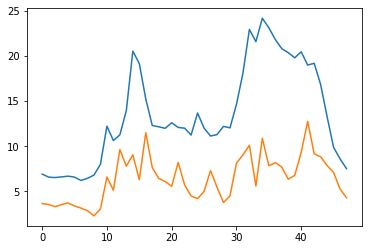

In [34]:
y = list(range(48))
plt.plot(y,F_i[:,9])
plt.plot(y,loads[h*(d-4):(d-3)*h])
plt.show

In [35]:
loadsReshape = np.reshape(loads, (365, 48))
UpperBound = np.quantile(loadsReshape, 0.75, axis=0)
LowerBound = np.quantile(loadsReshape, 0.25, axis=0)

In [102]:
day = np.asarray(loads[161*h:161*h+h])
MidPoint = (UpperBound - LowerBound) / 2
A_peak = 1.2

day_F1 = np.zeros(48)

for i in range(h):
    if (day[i] - MidPoint[i]) > MidPoint[i]:
        day_F1[i] = ((1-(UpperBound[i]-day[i])/(UpperBound[i]-MidPoint[i]))*A_peak)*day[i]
    else:
        day_F1[i] = ((1-(MidPoint[i]-day[i])/(MidPoint[i]-LowerBound[i]))*A_peak)*day[i]


<function matplotlib.pyplot.show(*args, **kw)>

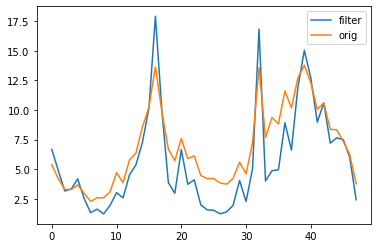

In [103]:
y = list(range(48))
plt.plot(y,day_F1, label="filter")
plt.plot(y,day, label="orig")
plt.legend()
plt.show

In [118]:
def WidenPeakLate(F2, Pmax, i, W):
    F2[i+1+W] = F2[i+1]
    diff = (F2[i] - F2[i+1])/(W+1)
    for j in range(W):
        F2[i+W-j] = F2[i+1+W] + (j+1)*diff
    return F2

def WidenPeakEarly(F2, Pmax, i, W):
    F2[i-1-W] = F2[i-1]
    diff = (F2[i] - F2[i-1])/(W+1)
    for j in range(W):
        F2[i-W+j] = F2[i-1-W] + (j+1)*diff
    return F2


In [124]:
day_F2 = np.array(day_F1)
F1 = np.array(day_F1)
Wpeak = 1
Npeak = 3

for i in range(Npeak):
    Pmax = max(F1)
    Pmax_pos = np.argmax(F1)
    #print(day_F2)
    day_F2 = WidenPeakLate(day_F2, Pmax, Pmax_pos, Wpeak)
    day_F2 = WidenPeakEarly(day_F2, Pmax, Pmax_pos, Wpeak)
    F1[Pmax_pos] = 0


<function matplotlib.pyplot.show(*args, **kw)>

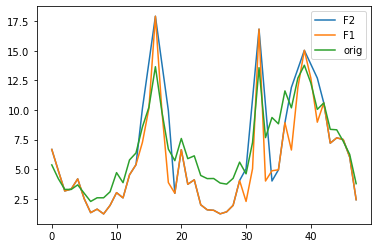

In [126]:
y = list(range(48))
plt.plot(y,day_F2, label="F2")
plt.plot(y,day_F1, label="F1")
plt.plot(y,day, label="orig")
plt.legend()
plt.show

In [253]:
day_F3 = savgol_filter(day_F2, 11, 6)
L_filter = np.array(day_F3)

<function matplotlib.pyplot.show(*args, **kw)>

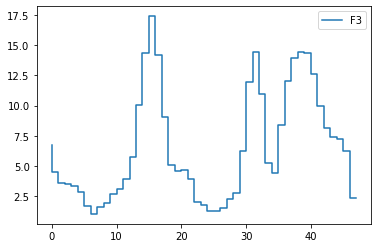

In [238]:
y = list(range(48))
plt.step(y,L_filter, label="F3")
#plt.plot(y,day_F2, label="F2")
#plt.plot(y,day_F1, label="F1")
#plt.plot(y,day, label="orig")
plt.legend()
plt.show

In [310]:
def FindSecondLargest(X):
    maxX = max(X)
    toDelete = []
    for i in range(len(X)):  
        if X[i] == maxX:
            toDelete.append(i)
    X_new = np.delete(X, toDelete)
    secondMax = max(X_new)
    secondPos = np.where(X==secondMax)[0][0]
    return secondMax


def SchedulingAlgorithmIteration(F, C, D, SOC):
    
    charge = np.zeros(48)
    StateOfCharge = np.zeros(48)

    SetPointValue = FindSecondLargest(F)
    for i, val in enumerate(F):
        # Check if value is above setpoint
        if val >= SetPointValue:
            j = 1
            # If so, find value to come down to
            diff = val - SetPointValue
            # Check if diff is greater than discharge rate
            if diff > D:
                diff = D
            # Set this peak to setpoint value
            F[i] -= diff
            # Loop to distribute this load
            while diff > 0:
                # Check if adding full charge would increase load to above setpoint
                if F[i-j] + C > SetPointValue:
                    # If so decrease diff
                    diff -= SetPointValue - F[i-j]
                    if diff < 0:
                        diff += SetPointValue - F[i-j]
                        break
                    # Then increase value up to setpoint
                    F[i-j] = SetPointValue
                else:
                    # Else, diff will decrease by full charge amount 
                    diff -= C
                    if diff < 0:
                        diff += C
                        break
                    # And full charge will be added to load
                    F[i-j] += C
                j += 1
            F[i-j] += diff
    return F

In [312]:
L_filter = np.array(day_F3)

e = 0.0001
M = 2
N = 48 
SOC = max(loads)*0.25
D = max(loads)*0.25
C = D/2
F = np.array(L_filter)
#print(F)

for i in range(M):
    Fplus1 = np.array(SchedulingAlgorithmIteration(F, C, D, SOC))
    #print(Fplus1)
    F = np.array(Fplus1)
    #print(F)
    

Charge = Fplus1 - day_F3
StateOfCharge = np.cumsum(Charge)

<bound method Figure.show of <Figure size 1080x576 with 2 Axes>>

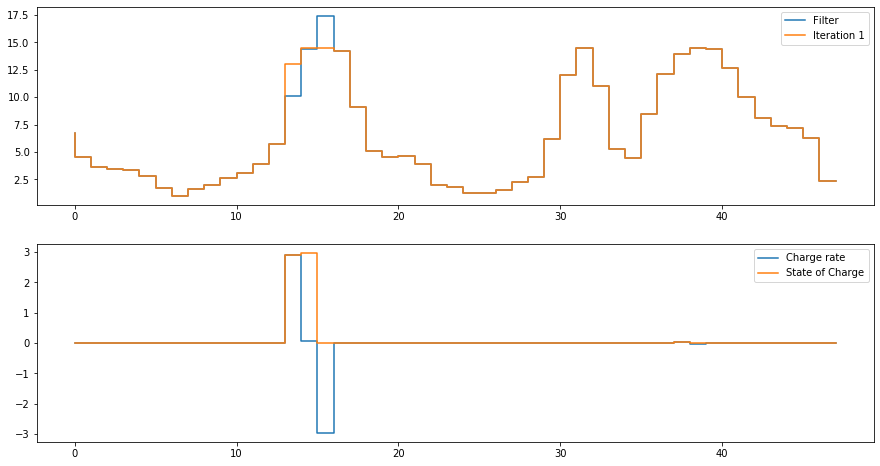

In [313]:
y = list(range(48))
fig, axs = plt.subplots(2)
axs[0].step(y,day_F3, label="Filter")
axs[0].step(y,F, label="Iteration 1")
axs[0].legend()
axs[1].step(y,Charge,label="Charge rate")
axs[1].step(y,StateOfCharge,label="State of Charge")
axs[1].legend()
#plt.plot(y,day_F1, label="F1")
#plt.plot(y,day, label="orig")
fig.set_figheight(8)
fig.set_figwidth(15)
fig.show

In [314]:
x = list(range(2))